In [1]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)

import pandas as pd
import numpy as np
from smt.surrogate_models import KRG
from smt.problems import WingWeight
from smt.sampling_methods import LHS
from sklearn.metrics import mean_squared_error


from smt.explainability_tools import PartialDependenceDisplay, PDFeatureImportanceDisplay
from smt.explainability_tools import partial_dependence, pd_feature_importance
from smt.explainability_tools import pd_pairwise_interaction, pd_overall_interaction

import matplotlib.pyplot as plt


In [2]:
def analytical_function(x):
    y = 0.2 * x[:, 0] + 0.4 * x[:, 1]
    return y

sampling = LHS(xlimits = np.array([[0, 1], [0, 1],]), 
 criterion="ese", 
 random_state=1
)
ndoe = 200
X = sampling(ndoe)
y = analytical_function(X)

n_train = int(0.8*ndoe)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

kriging_model = KRG(
    theta0=[1e-2]*X_tr.shape[1],
    print_prediction = False
    )
kriging_model.set_training_values(
    X_tr, 
    y_tr
    )

kriging_model.train()
y_pred = kriging_model.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")



___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 160
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  2.1756418
RMSE: 0.0000


In [3]:
model = kriging_model
features = [
    0, 
    1, 
    (0, 1)
]
pd_results = partial_dependence(
    model, 
    X_tr, 
    features,
    method="sample",
)

In [4]:
combined_pd = pd_results[2]["average"]
pd_0 = pd_results[0]["average"]
pd_1 = pd_results[1]["average"]

combined_pd_centered = combined_pd - combined_pd.mean()
pd_0_centered = pd_0 - pd_0.mean()
pd_1_centered = pd_1 - pd_1.mean()


In [5]:
((combined_pd - pd_0 - pd_1)**2).sum() / (combined_pd**2).sum()

0.8515760304767759

In [6]:
((combined_pd_centered - pd_0_centered - pd_1_centered)**2).sum() /  (combined_pd_centered**2).sum()

5.273184241490196e-15

# dsdsd

In [7]:
def analytical_function(x):
    y = 0.2 * x[:, 0] + 0.4 * x[:, 1] + 0.3 * x[:, 2] + 10 * x[:, 0] * x[:, 1] 
    return y

sampling = LHS(xlimits = np.array([[0, 1], [0, 1], [0, 1]]), 
 criterion="ese", 
 random_state=1
)
ndoe = 200
X = sampling(ndoe)
y = analytical_function(X)

n_train = int(0.8*ndoe)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

kriging_model = KRG(
    theta0=[1e-2]*X_tr.shape[1],
    print_prediction = False
    )
kriging_model.set_training_values(
    X_tr, 
    y_tr
    )

kriging_model.train()
y_pred = kriging_model.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 160
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.9478312
RMSE: 0.0000


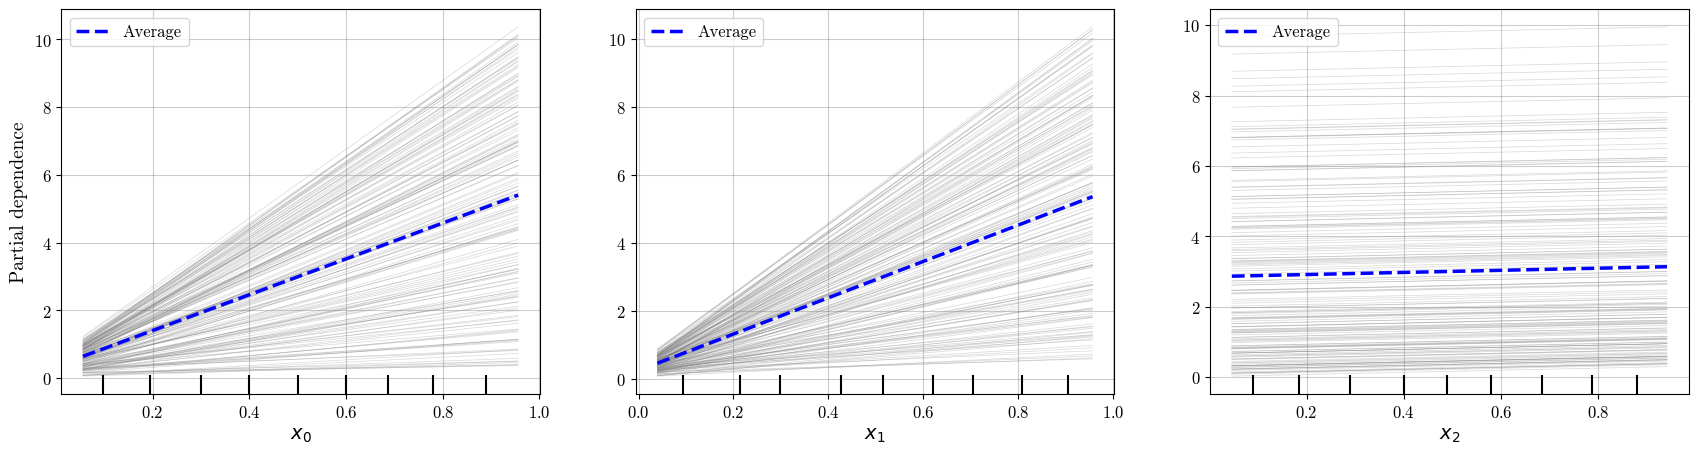

In [8]:
model = kriging_model
features = [
    0, 
    1, 
    2, 
]
pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X_tr, 
    features, 
    grid_resolution=100, 
    kind='both',
    centered=False,
)

In [11]:
feature_pairs = [
    (0, 1), 
    (0, 2), 
    (1, 2), 
]

pair_h_scores = pd_pairwise_interaction(
    feature_pairs, 
    X_tr, 
    kriging_model,
)
pair_h_scores

[0.12146756018238496, 1.7587756923765748e-14, 1.9298359486152622e-14]

In [13]:
features = [0, 1, 2]
overall_h_scores = pd_overall_interaction(
    features, 
    X_tr, 
    kriging_model,
)
overall_h_scores

[0.12098841092362907, 0.12098840997125998, 2.2398110229643144e-14]